# 2 entrenamiento_modelo.ipynb

Este notebook entrena un modelo de aprendizaje profundo (Deep Learning) para reconocer letras del lenguaje de señas usando los *landmarks* generados por MediaPipe.

## Etapas del notebook:
1. Importar librerías
2. Cargar los datos limpios
3. Separar características y etiquetas
4. Codificar las etiquetas
5. Dividir el dataset en entrenamiento y prueba
6. Normalizar los datos
7. Crear el modelo neuronal
8. Compilar el modelo
9. Entrenar el modelo
10. Visualizar resultados


## 1 Importar librerías

Importamos todas las librerías necesarias para el manejo de datos, construcción del modelo y visualización de resultados.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

Si hay errores con tensorflow, desistale estas dependencias y vuelva a instalar


pip install numpy==1.24.3
pip install tensorflow==2.15.0
pip install opencv-python==4.8.1.78 opencv-contrib-python==4.8.1.78

In [2]:
import tensorflow as tf
import mediapipe as mp
import cv2
import numpy as np

print("TensorFlow:", tf.__version__)
print("MediaPipe:", mp.__version__)
print("OpenCV:", cv2.__version__)
print("NumPy:", np.__version__)

TensorFlow: 2.19.1
MediaPipe: 0.10.21
OpenCV: 4.11.0
NumPy: 1.26.4


## 2 Cargar los datos limpios

Cargamos el dataset que fue previamente limpiado en el notebook `01_limpieza_datos.ipynb`. Este archivo contiene los landmarks de las manos normalizados y una columna con la etiqueta (letra).

In [3]:
PROCESSED_DIR = "../dataset_landmarks_limpios"   # <<== ajusta aquí si hace falta

X_train = np.load(f"{PROCESSED_DIR}/X_train.npy")
y_train = np.load(f"{PROCESSED_DIR}/y_train.npy")
X_val   = np.load(f"{PROCESSED_DIR}/X_val.npy")
y_val   = np.load(f"{PROCESSED_DIR}/y_val.npy")
X_test  = np.load(f"{PROCESSED_DIR}/X_test.npy")
y_test  = np.load(f"{PROCESSED_DIR}/y_test.npy")

# Si tienes label2id.json
import json
with open(f"{PROCESSED_DIR}/label2id.json","r") as f:
    label2id = json.load(f)
id2label = {int(v):k for k,v in label2id.items()}

print("Shapes:")
print(" X_train:", X_train.shape)
print(" y_train:", y_train.shape)
print(" X_val:  ", X_val.shape)
print(" y_val:  ", y_val.shape)
print(" X_test: ", X_test.shape)
print(" y_test: ", y_test.shape)
print("Num classes:", len(label2id))


Shapes:
 X_train: (33459, 63)
 y_train: (33459,)
 X_val:   (7170, 63)
 y_val:   (7170,)
 X_test:  (7170, 63)
 y_test:  (7170,)
Num classes: 35


In [4]:
# Si y_train es vector de enteros -> one-hot
if y_train.ndim == 1 or (y_train.ndim == 2 and y_train.shape[1] == 1):
    num_classes = len(label2id)
    y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_ohe   = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_ohe  = tf.keras.utils.to_categorical(y_test, num_classes)
else:
    # Si ya están en one-hot:
    y_train_ohe = y_train
    y_val_ohe   = y_val
    y_test_ohe  = y_test
    num_classes = y_train_ohe.shape[1]

print("y_train_ohe shape:", y_train_ohe.shape)


y_train_ohe shape: (33459, 35)


In [5]:
input_dim = X_train.shape[1]
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train_ohe,
    validation_data=(X_val, y_val_ohe),
    epochs=50,
    batch_size=64,
    verbose=2
)


c:\Users\julia\anaconda3\envs\senias_viz\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,795 (210.14 KB)

 Trainable params: 53,795 (210.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
523/523 - 5s - 10ms/step - accuracy: 0.7857 - loss: 0.8451 - val_accuracy: 0.9452 - val_loss: 0.1926
Epoch 2/50
523/523 - 3s - 6ms/step - accuracy: 0.9507 - loss: 0.1918 - val_accuracy: 0.9750 - val_loss: 0.0945
Epoch 3/50
523/523 - 3s - 5ms/step - accuracy: 0.9686 - loss: 0.1210 - val_accuracy: 0.9806 - val_loss: 0.0743
Epoch 4/50
523/523 - 2s - 4ms/step - accuracy: 0.9759 - loss: 0.0939 - val_accuracy: 0.9862 - val_loss: 0.0538
Epoch 5/50
523/523 - 1s - 2ms/step - accuracy: 0.9798 - loss: 0.0789 - val_accuracy: 0.9883 - val_loss: 0.0488
Epoch 6/50
523/523 - 2s - 4ms/step - accuracy: 0.9824 - loss: 0.0658 - val_accuracy: 0.9897 - val_loss: 0.0449
Epoch 7/50
523/523 - 2s - 3ms/step - accuracy: 0.9838 - loss: 0.0596 - val_accuracy: 0.9904 - val_loss: 0.0412
Epoch 8/50
523/523 - 2s - 4ms/step - accuracy: 0.9854 - loss: 0.0523 - val_accuracy: 0.9919 - val_loss: 0.0374
Epoch 9/50
523/523 - 2s - 4ms/step - accuracy: 0.9872 - loss: 0.0488 - val_accuracy: 0.9904 - val_loss: 0.0383


## 2 Cargar los datos limpios

Cargamos el dataset que fue previamente limpiado en el notebook `01_limpieza_datos.ipynb`. Este archivo contiene los landmarks de las manos normalizados y una columna con la etiqueta (letra).

Test loss: 0.01951632834970951    Test accuracy: 0.9965132474899292
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       146
          10       1.00      1.00      1.00       402
           2       1.00      1.00      1.00       148
           4       1.00      0.99      0.99       150
           5       1.00      1.00      1.00       148
           7       1.00      1.00      1.00       150
           8       1.00      1.00      1.00       214
           A       1.00      1.00      1.00       303
           B       0.99      1.00      1.00       463
           C       1.00      1.00      1.00       303
           D       1.00      0.99      1.00       303
           E       1.00      1.00      1.00       323
           F       1.00      1.00      1.00       306
           G       0.85      0.85      0.85        13
           H       1.00      0.79      0.88        14
           I       1.00

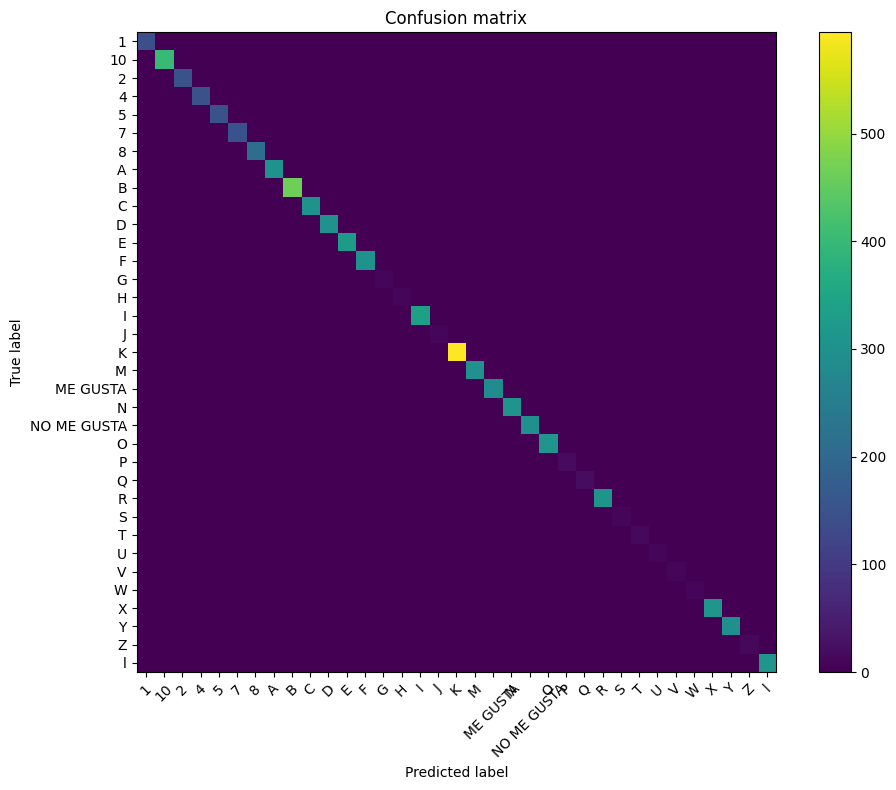

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ===========================
#      EVALUACIÓN DEL MODELO
# ===========================

loss, acc = model.evaluate(X_test, y_test_ohe, verbose=0)
print("Test loss:", loss, "   Test accuracy:", acc)

# ===========================
#       PREDICCIONES
# ===========================

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

# Reporte de clasificación
label_names = [id2label[i] for i in range(num_classes)]
print(classification_report(y_true, y_pred, target_names=label_names))

# ===========================
#     MATRIZ DE CONFUSIÓN
# ===========================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(np.arange(len(label_names)), label_names, rotation=45)
plt.yticks(np.arange(len(label_names)), label_names)
plt.tight_layout()
plt.show()



In [7]:
import os
import pickle

# Crear carpeta modelos si no existe
os.makedirs("../scr/modelos", exist_ok=True)

# Guardar el modelo entrenado
model.save("../scr/modelos/modelo_signos.h5")
print(" Modelo guardado como modelo_signos.h5")

# Guardar el diccionario id2label (muy importante para la detección en tiempo real)
with open("../scr/modelos/id2label.pkl", "wb") as f:
    pickle.dump(id2label, f)
print(" id2label.pkl guardado")

# Guardar también label2id
with open("../scr/modelos/label2id.pkl", "wb") as f:
    pickle.dump(label2id, f)
print(" label2id.pkl guardado")


 Modelo guardado como modelo_signos.h5
 id2label.pkl guardado
 label2id.pkl guardado
